In [2]:
from turtle import shape
import nibabel as nib
import os
import sys
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import cv2
from PIL import Image
from matplotlib import cm
import pandas as pd
import imblearn
import re

# Setting paths for different folders
FLAIR_scan = r'C:\Users\ellen\Documents\ew-honoursthesis\Data\forAudrey.tar\Normalised\FLAIRinT1space_withLacunes_35.tar'
T1_Lacunes_Incorrect = r'C:\Users\ellen\Documents\ew-honoursthesis\Data\forAudrey.tar\Original\lacune_T1space.tar'
T1_Lacunes_Correct = r'C:\Users\ellen\Documents\ew-honoursthesis\Data\forAudrey.tar\Original\lacune_T1space_JiyangCorrected20210920'
T1_scan = r'C:\Users\ellen\Documents\ew-honoursthesis\Data\forAudrey.tar\Normalised\T1_withLacunes_35.tar'
T1_Soft_Tissue = r'C:\Users\ellen\Documents\ew-honoursthesis\Data\forAudrey.tar\Normalised\T1softTiss_withLacunes_35.tar'
T1_Soft_Tissue_Mask = r'C:\Users\ellen\Documents\ew-honoursthesis\Data\forAudrey.tar\Original\T1softTissMask_withLacunes_35.tar'
T1_Soft_Tissue_Binary_Mask = r'C:\Users\ellen\Documents\ew-honoursthesis\Data\forAudrey.tar\Original\T1softTissMask_withLacunes_35_binary.tar'


In [3]:
def read_data():
    #Read all data into list
    T1_scan_data = []
    for file in os.listdir(T1_scan):
        if file.endswith(".nii.gz"):
            Data_list = []
            file_id = int(re.search(r'\d+', file)[0])
            imgpath = os.path.join(T1_scan, file)
            img = nib.load(imgpath)
            data = img.get_fdata()
            Data_list.append(file_id)
            Data_list.append(data)
            T1_scan_data.append(Data_list)

    #Read all FLAIR data into list
    FLAIR_scan_data = []
    for file in os.listdir(FLAIR_scan):
        if file.endswith(".nii.gz"):
            Data_list = []
            file_id = int(re.search(r'\d+', file)[0])
            imgpath = os.path.join(FLAIR_scan, file)
            img = nib.load(imgpath)
            data = img.get_fdata()
            Data_list.append(file_id)
            Data_list.append(data)
            FLAIR_scan_data.append(Data_list)

    #Lacune Exists
    Lacune_indicator_data = []
    for file in os.listdir(T1_Lacunes_Correct):
        if file.endswith(".nii.gz"):
            Data_list = []
            file_id = int(re.search(r'\d+', file)[0])
            imgpath = os.path.join(T1_Lacunes_Correct, file)
            img = nib.load(imgpath)
            data = img.get_fdata()
            Data_list.append(file_id)
            Data_list.append(data)
            Lacune_indicator_data.append(Data_list)

    Soft_tiss_data = []
    for file in os.listdir(T1_Soft_Tissue):
        if file.endswith(".nii.gz"):
            Data_list = []
            file_id = int(re.search(r'\d+', file)[0])
            imgpath = os.path.join(T1_Soft_Tissue, file)
            img = nib.load(imgpath)
            data = img.get_fdata()
            Data_list.append(file_id)
            Data_list.append(data)
            Soft_tiss_data.append(Data_list)

    return T1_scan_data, FLAIR_scan_data, Lacune_indicator_data, Soft_tiss_data
T1_scan_data, FLAIR_scan_data, Lacune_indicator_data, Soft_tiss_data = read_data()
print("complete")

complete


In [346]:
def sample_lacunes(T1_scan_data, FLAIR_scan_data, Lacune_indicator_data, Soft_tiss_data):
    # Lacune not as centred, random sampling all around brain
    X_train_3D_lacune = []
    X_test_3D_lacune = []
    Y_train_3D_lacune = []
    Y_test_3D_lacune = []
    Y_train_segment_3D_lacune = []
    Y_test_segment_3D_lacune = []

    brain_image = 0
    for file in os.listdir(T1_Soft_Tissue_Binary_Mask):
        if file.endswith(".nii.gz"):
            file_id = int(re.search(r'\d+', file)[0])
            imgpath = os.path.join(T1_Soft_Tissue_Binary_Mask, file)
            img = nib.load(imgpath)
            data = img.get_fdata()
            data = data.astype(np.uint8)  # converting array of ints to floats
            T1_data_scans = T1_scan_data[brain_image][1]
            FLAIR_data_scans = FLAIR_scan_data[brain_image][1]
            SoftTiss = Soft_tiss_data[brain_image][1]
            Lacune_data = Lacune_indicator_data[brain_image][1]

            #Sample lacunes
            for x in range(0, data.shape[0]):
                for y in range(0, data.shape[1]):
                    for z in range(0, data.shape[2]):
                        #filter for soft tissue
                        if (x < 50) | (y < 70) | (z < 15) | (x > 200) | (y > 210) | (z > 165):
                            next
                        else:
                            brain_values = []
                            brain_values.append(file_id)
                            brain_values.append(x)
                            brain_values.append(y)
                            brain_values.append(z)

                            patch_3D_T1 = T1_data_scans[x-15:x+15, y-15:y+15, z-15:z+15]
                            brain_values.append(patch_3D_T1)

                            patch_3D_FLAIR = FLAIR_data_scans[x-15:x+15, y-15:y+15, z-15:z+15]
                            brain_values.append(patch_3D_FLAIR)

                            patch_3D_softtiss_binary = data[x-15:x+15, y-15:y+15, z-15:z+15]
                            brain_values.append(patch_3D_softtiss_binary)

                            patch_3D_softtiss = SoftTiss[x-15:x+15, y-15:y+15, z-15:z+15]
                            brain_values.append(patch_3D_softtiss)

                            lacune_binary = Lacune_data[x-15:x+15, y-15:y+15, z-15:z+15] 

                            if brain_image <= 24:
                                if (Lacune_data[x,y,z] == 1):
                                    X_train_3D_lacune.append(brain_values)
                                    Y_train_3D_lacune.append(1)
                                    Y_train_segment_3D_lacune.append(lacune_binary)

                            else:
                                if (Lacune_data[x,y,z] == 1):
                                    X_test_3D_lacune.append(brain_values)
                                    Y_test_3D_lacune.append(1)
                                    Y_test_segment_3D_lacune.append(lacune_binary)
                            
            brain_image += 1
            print(brain_image)
    return X_train_3D_lacune, X_test_3D_lacune, Y_train_3D_lacune, Y_test_3D_lacune, Y_train_segment_3D_lacune, Y_test_segment_3D_lacune
X_train_3D_lacune, X_test_3D_lacune, Y_train_3D_lacune, Y_test_3D_lacune, Y_train_segment_3D_lacune, Y_test_segment_3D_lacune = sample_lacunes(T1_scan_data, FLAIR_scan_data, Lacune_indicator_data, Soft_tiss_data)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35


In [347]:
def non_lacune_sampling(T1_scan_data, FLAIR_scan_data, Lacune_indicator_data, Soft_tiss_data):
    # Lacune not as centred, random sampling all around brain
    X_train_3D_nlacune = []
    X_test_3D_nlacune = []
    Y_train_3D_nlacune = []
    Y_test_3D_nlacune = []
    Y_train_segment_3D_nlacune = []
    Y_test_segment_3D_nlacune = []

    brain_image = 0
    for file in os.listdir(T1_Soft_Tissue_Binary_Mask):
        if file.endswith(".nii.gz"):
            file_id = int(re.search(r'\d+', file)[0])
            imgpath = os.path.join(T1_Soft_Tissue_Binary_Mask, file)
            img = nib.load(imgpath)
            data = img.get_fdata()
            data = data.astype(np.uint8)  # converting array of ints to floats
            T1_data_scans = T1_scan_data[brain_image][1]
            FLAIR_data_scans = FLAIR_scan_data[brain_image][1]
            SoftTiss = Soft_tiss_data[brain_image][1]
            Lacune_data = Lacune_indicator_data[brain_image][1]
            
            #Sample lacunes
            for x in range(0, data.shape[0], 15):
                for y in range(0, data.shape[1], 15):
                    for z in range(0, data.shape[2], 15):
                        #filter for soft tissue
                        if (x < 50) | (y < 70) | (z < 15) | (x > 200) | (y > 210) | (z > 165):
                            next
                        else:
                            brain_values = []
                            brain_values.append(file_id)
                            brain_values.append(x)
                            brain_values.append(y)
                            brain_values.append(z)

                            patch_3D_T1 = T1_data_scans[x-15:x+15, y-15:y+15, z-15:z+15]
                            brain_values.append(patch_3D_T1)

                            patch_3D_FLAIR = FLAIR_data_scans[x-15:x+15, y-15:y+15, z-15:z+15]
                            brain_values.append(patch_3D_FLAIR)

                            patch_3D_softtiss_binary = data[x-15:x+15, y-15:y+15, z-15:z+15]
                            brain_values.append(patch_3D_softtiss_binary)

                            patch_3D_softtiss = SoftTiss[x-15:x+15, y-15:y+15, z-15:z+15]
                            brain_values.append(patch_3D_softtiss)

                            lacune_binary = Lacune_data[x-15:x+15, y-15:y+15, z-15:z+15]

                            if brain_image <= 24:
                                # No lacune exists in the 3D patch, add to train set
                                if any(1 in sublist for sublist in lacune_binary):
                                    next
                                else:
                                    X_train_3D_nlacune.append(brain_values)
                                    Y_train_3D_nlacune.append(0)
                                    Y_train_segment_3D_nlacune.append(lacune_binary)
                                    
                            else:
                                if any(1 in sublist for sublist in lacune_binary):
                                    next
                                else:
                                    X_test_3D_nlacune.append(brain_values)
                                    Y_test_3D_nlacune.append(0)
                                    Y_test_segment_3D_nlacune.append(lacune_binary)
            brain_image += 1
            print(brain_image)

    return X_train_3D_nlacune, X_test_3D_nlacune, Y_train_3D_nlacune, Y_test_3D_nlacune, Y_train_segment_3D_nlacune, Y_test_segment_3D_nlacune
X_train_3D_nlacune, X_test_3D_nlacune, Y_train_3D_nlacune, Y_test_3D_nlacune, Y_train_segment_3D_nlacune, Y_test_segment_3D_nlacune = non_lacune_sampling(T1_scan_data, FLAIR_scan_data, Lacune_indicator_data, Soft_tiss_data)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35


In [348]:
X_train = np.concatenate((X_train_3D_lacune, X_train_3D_nlacune), axis=0)
X_test = np.concatenate((X_test_3D_lacune, X_test_3D_nlacune), axis=0)
Y_train = np.concatenate((Y_train_3D_lacune, Y_train_3D_nlacune), axis=0)
Y_test = np.concatenate((Y_test_3D_lacune, Y_test_3D_nlacune), axis=0)
Y_train_segment = np.concatenate((Y_train_segment_3D_lacune, Y_train_segment_3D_nlacune), axis=0)
Y_test_segment = np.concatenate((Y_test_segment_3D_lacune, Y_test_segment_3D_nlacune), axis=0)
print(len(X_train_3D_nlacune))
print(len(X_train_3D_lacune))
print("done")

27106
2351
done


In [ ]:
import scipy.misc
rgb = scipy.misc.toimage(X_train[4][4][:, 15, :])
rgb

In [18]:
np.mean(X_train[3000][4][7:23, 7:23, 7:23])/((sum(sum(sum(X_train[3000][4]))) - sum(sum(sum(X_train[3000][4][7:23, 7:23, 7:23]))))/22904)

0.980886333907486

In [202]:
X_train[5000][6][13:17, 13:17, 13:17]

array([[[0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 1]],

       [[0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0]],

       [[0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0]],

       [[0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0]]], dtype=uint8)

In [492]:
import matplotlib.pyplot as plt

from skimage import data, color, img_as_ubyte
from skimage.feature import canny
from skimage.transform import hough_ellipse
from skimage.draw import ellipse_perimeter

# Load picture, convert to grayscale and detect edges
image_rgb = X_train[500][4][:, 15, :]*255
image_gray = color.rgb2gray(image_rgb)
img_blur = cv2.GaussianBlur(image_gray, (7,7), 0)
edges = canny(img_blur)
th3 = cv2.adaptiveThreshold(img,200, 255, cv2.THRESH_BINARY)
plt.imshow(th3, cmap="gray", origin="lower")
# Perform a Hough Transform
# The accuracy corresponds to the bin size of a major axis.
# The value is chosen in order to get a single high accumulator.
# The threshold eliminates low accumulators
result = hough_ellipse(edges, accuracy=20, threshold=250,
                       min_size=100, max_size=120)
result.sort(order='accumulator')
#print(edges)

# Estimated parameters for the ellipse
best = list(result[-1])
yc, xc, a, b = [int(round(x)) for x in best[1:5]]
orientation = best[5]

# Draw the ellipse on the original image
cy, cx = ellipse_perimeter(yc, xc, a, b, orientation)
image_rgb[cy, cx] = (0, 0, 255)
# Draw the edge (white) and the resulting ellipse (red)
edges = color.gray2rgb(img_as_ubyte(edges))
edges[cy, cx] = (250, 0, 0)

fig2, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, figsize=(8, 4), sharex=True,
                                sharey=True,
                                subplot_kw={'adjustable':'box'})

ax1.set_title('Original picture')
ax1.imshow(image_rgb)

ax2.set_title('Edge (white) and result (red)')
ax2.imshow(edges)

error: OpenCV(4.5.5) :-1: error: (-5:Bad argument) in function 'adaptiveThreshold'
> Overload resolution failed:
>  - adaptiveThreshold() missing required argument 'blockSize' (pos 5)
>  - adaptiveThreshold() missing required argument 'blockSize' (pos 5)


In [ ]:
# global thresholding
kernel = (5,5)
img = X_train[100][7][:, 15, :]
opening = cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel)
im_bin = (img < 0.25)*img
#th1 = cv2.threshold(img,0.25,0.5,cv2.THRESH_BINARY)
#contours = cv2.findContours(im_bin, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)


edges = canny(im_bin)
plt.imshow(edges, cmap="gray", origin="lower")


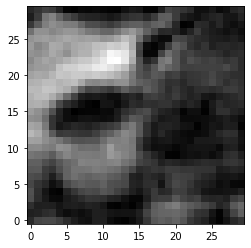

In [497]:
filterSize =(16, 16)
kernel = cv2.getStructuringElement(cv2.MORPH_RECT,
                                   filterSize)
# Reading the image named 'input.jpg'
input_image = X_train[520][4][:, 15, :]
  
# Applying the Black-Hat operation
tophat_img = cv2.morphologyEx(input_image, 
                              cv2.MORPH_TOPHAT,
                              kernel)

plt.imshow(tophat_img, cmap="gray", origin="lower")
plt.show()

In [ ]:
# binarization

In [447]:
a3d = Image.fromarray(tophat_img)
a3d = a3d.convert("L")
a3d.save('image.png')

In [448]:
a3d = np.array(Image.open('image.png'))
a3d.size

900

In [449]:
a3d = cv2.medianBlur(img,5)
#cimg = cv2.cvtColor(input_image,cv2.COLOR_GRAY2BGR)
# Find circles
circles = cv2.HoughCircles(a3d,cv2.HOUGH_GRADIENT,1,10,
                            param1=50,param2=10,minRadius=3,maxRadius=15)
#circles = np.uint16(np.around(circles))

for i in circles[0,:]:
    # draw the outer circle
    cv2.circle(cimg,(i[0],i[1]),i[2],(0,255,0),2)
    # draw the center of the circle
    cv2.circle(cimg,(i[0],i[1]),2,(0,0,255),3)
cv2.imshow('detected circles',a3d)
cv2.waitKey(0)
cv2.destroyAllWindows()

TypeError: 'NoneType' object is not subscriptable

TypeError: Image data of dtype object cannot be converted to float

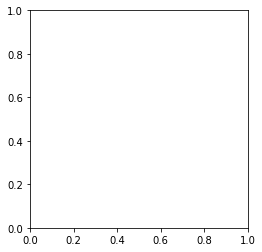

In [441]:
plt.imshow(circles, cmap="gray", origin="lower")

In [383]:
img = Image.fromarray(np.uint8(tophat_img*255) , 'L')
img.show()

In [368]:
from sklearn.cluster import KMeans
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(img)
    distortions.append(kmeanModel.inertia_)

C:\Users\ellen\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1037: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  "KMeans is known to have a memory leak on Windows "


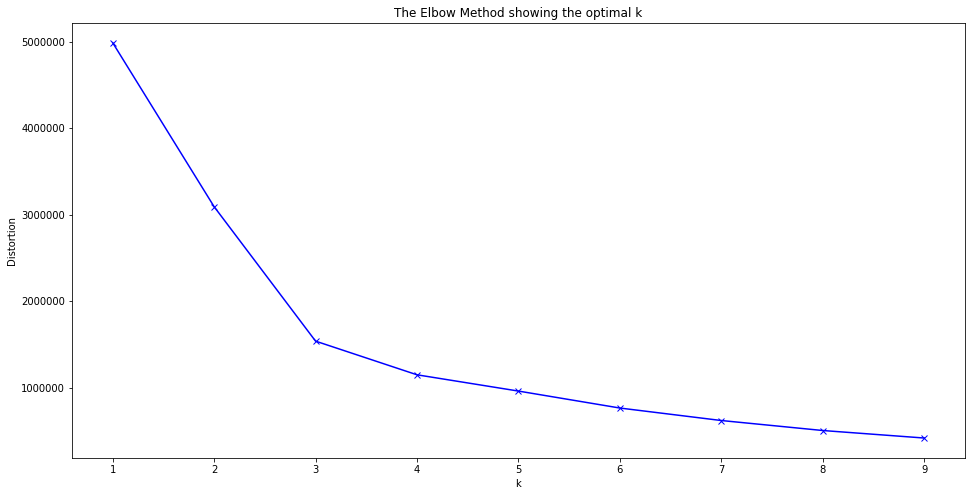

In [369]:
plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [351]:
kmeanModel = KMeans(n_clusters=2)
kmeanModel.fit(X_train[4][4][:, 15, :])

KMeans(n_clusters=2)

In [370]:
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)
k = 3
_, labels, (centers) = cv2.kmeans(img, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)
centers = np.uint8(centers)
labels = labels.flatten()
segmented_image = centers[labels.flatten()]
# reshape back to the original image dimension
segmented_image = segmented_image.reshape(image.shape)
# show the image
plt.imshow(segmented_image)
plt.show()

error: OpenCV(4.5.5) :-1: error: (-5:Bad argument) in function 'kmeans'
> Overload resolution failed:
>  - data is not a numpy array, neither a scalar
>  - Expected Ptr<cv::UMat> for argument 'data'


In [60]:
np.mean(X_train[index][4][13:17, 13:17, 13:17])/((sum(sum(sum(X_train[index][4][10:20, 10:20, 10:20]))) - sum(sum(sum(X_test[index][4][13:17, 13:17, 13:17]))))/936)

IndexError: index 11830 is out of bounds for axis 0 with size 11830

In [64]:
(sum(sum(sum(X_train[index][4][10:20, 10:20, 10:20]))))

304.9265915751457

In [68]:
sum(sum(sum(X_train[index][4][13:17, 13:17, 13:17])))

15.553691022098064

In [220]:
#Features
min_T1 = []
med_T1 = []
mid_T1 = []
mid_small_ratio_T1 = []
mid_med_ratio_T1 = []
mid_large_ratio_T1 = []
mid_small_ratio_T1_inc = []
mid_med_ratio_T1_inc = []
mid_large_ratio_T1_inc = []
mean_T1 = []
max_T1 = []
min_FLAIR = []
med_FLAIR = []
mid_FLAIR = []
mid_small_ratio_FLAIR = []
mid_med_ratio_FLAIR = []
mid_large_ratio_FLAIR = []
mid_small_ratio_FLAIR_inc = []
mid_med_ratio_FLAIR_inc = []
mid_large_ratio_FLAIR_inc = []
mean_FLAIR = []
max_FLAIR = []
density_diff = []
sum_soft_tiss_binary = []
sum_percent_soft_tiss = []
min_st = []
med_st = []
mid_st = []
mid_small_ratio_st = []
mid_med_ratio_st = []
mid_large_ratio_st = []
mid_small_ratio_st_inc = []
mid_med_ratio_st_inc = []
mid_large_ratio_st_inc = []
mean_st = []
max_st = []
x = []
y = []
z = []

for index in range(len(X_train)):
    min_T1.append(np.min(X_train[index][4]))
    med_T1.append(np.median(X_train[index][4]))
    mid_T1.append(X_train[index][4][10,10,10])
    mid_small_ratio_T1.append(np.mean(X_train[index][4][13:17, 13:17, 13:17])/((sum(sum(sum(X_train[index][4][10:20, 10:20, 10:20]))) - sum(sum(sum(X_train[index][4][13:17, 13:17, 13:17]))))/936))
    mid_med_ratio_T1.append(np.mean(X_train[index][4][10:20, 10:20, 10:20])/((sum(sum(sum(X_train[index][4][7:23, 7:23, 7:23]))) - sum(sum(sum(X_train[index][4][10:20, 10:20, 10:20]))))/3096))
    mid_large_ratio_T1.append(np.mean(X_train[index][4][7:23, 7:23, 7:23])/((sum(sum(sum(X_train[index][4][4:27, 4:27, 4:27]))) - sum(sum(sum(X_train[index][4][7:23, 7:23, 7:23]))))/9071))
    mid_small_ratio_T1_inc.append(np.mean(X_train[index][4][13:17, 13:17, 13:17])/((sum(sum(sum(X_train[index][4][10:20, 10:20, 10:20]))))/1000))
    mid_med_ratio_T1_inc.append(np.mean(X_train[index][4][10:20, 10:20, 10:20])/((sum(sum(sum(X_train[index][4][7:23, 7:23, 7:23]))))/4096))
    mid_large_ratio_T1_inc.append(np.mean(X_train[index][4][7:23, 7:23, 7:23])/((sum(sum(sum(X_train[index][4][4:27, 4:27, 4:27]))))/12167))
    mean_T1.append(np.mean(X_train[index][4]))
    max_T1.append(np.max(X_train[index][4]))
    min_FLAIR.append(np.min(X_train[index][5]))
    med_FLAIR.append(np.median(X_train[index][5]))
    mid_FLAIR.append(X_train[index][5][15, 15, 15])
    mid_small_ratio_FLAIR.append(np.mean(X_train[index][5][13:17, 13:17, 13:17])/((sum(sum(sum(X_train[index][5][10:20, 10:20, 10:20]))) - sum(sum(sum(X_train[index][5][13:17, 13:17, 13:17]))))/936))
    mid_med_ratio_FLAIR.append(np.mean(X_train[index][5][10:20, 10:20, 10:20])/((sum(sum(sum(X_train[index][5][7:23, 7:23, 7:23]))) - sum(sum(sum(X_train[index][5][10:20, 10:20, 10:20]))))/3096))
    mid_large_ratio_FLAIR.append(np.mean(X_train[index][5][7:23, 7:23, 7:23])/((sum(sum(sum(X_train[index][5][4:27, 4:27, 4:27]))) - sum(sum(sum(X_train[index][5][7:23, 7:23, 7:23]))))/9071))
    mid_small_ratio_FLAIR_inc.append(np.mean(X_train[index][5][13:17, 13:17, 13:17])/((sum(sum(sum(X_train[index][5][10:20, 10:20, 10:20]))))/1000))
    mid_med_ratio_FLAIR_inc.append(np.mean(X_train[index][5][10:20, 10:20, 10:20])/((sum(sum(sum(X_train[index][5][7:23, 7:23, 7:23]))))/4096))
    mid_large_ratio_FLAIR_inc.append(np.mean(X_train[index][5][7:23, 7:23, 7:23])/((sum(sum(sum(X_train[index][5][4:27, 4:27, 4:27]))))/12167))
    mean_FLAIR.append(np.mean(X_train[index][5]))
    max_FLAIR.append(np.max(X_train[index][5]))
    density_diff.append(X_train[index][5][15, 15, 15] - X_train[index][4][15, 15, 15])
    sum_soft_tiss_binary.append(sum(sum(sum(X_train[index][6]))))
    sum_percent_soft_tiss.append(sum(sum(sum(X_train[index][7]))))
    min_st.append(np.min(X_train[index][6]))
    med_st.append(np.median(X_train[index][6]))
    mid_st.append(X_train[index][6][15, 15, 15])
    mid_small_ratio_st.append(np.mean(X_train[index][6][13:17, 13:17, 13:17])/((sum(sum(sum(X_train[index][6][10:20, 10:20, 10:20]))) - sum(sum(sum(X_train[index][6][13:17, 13:17, 13:17]))))/936))
    mid_med_ratio_st.append(np.mean(X_train[index][6][10:20, 10:20, 10:20])/((sum(sum(sum(X_train[index][6][7:23, 7:23, 7:23]))) - sum(sum(sum(X_train[index][6][10:20, 10:20, 10:20]))))/3096))
    mid_large_ratio_st.append(np.mean(X_train[index][6][7:23, 7:23, 7:23])/((sum(sum(sum(X_train[index][6][4:27, 4:27, 4:27]))) - sum(sum(sum(X_train[index][6][7:23, 7:23, 7:23]))))/9071))
    mid_small_ratio_st_inc.append(np.mean(X_train[index][6][13:17, 13:17, 13:17])/((sum(sum(sum(X_train[index][6][10:20, 10:20, 10:20]))))/1000))
    mid_med_ratio_st_inc.append(np.mean(X_train[index][6][10:20, 10:20, 10:20])/((sum(sum(sum(X_train[index][6][7:23, 7:23, 7:23]))))/4096))
    mid_large_ratio_st_inc.append(np.mean(X_train[index][6][7:23, 7:23, 7:23])/((sum(sum(sum(X_train[index][6][4:27, 4:27, 4:27]))))/12167))
    mean_st.append(np.mean(X_train[index][6]))
    max_st.append(np.max(X_train[index][6]))
    x.append(X_train[index][1])
    y.append(X_train[index][2])
    z.append(X_train[index][3])


print(len(min_T1))
print(len(med_T1))
print(len(mid_T1))
print(len(mid_small_ratio_T1))
print(len(mid_med_ratio_T1))
print(len(mid_large_ratio_T1))
print(len(mid_small_ratio_T1_inc))
print(len(mid_med_ratio_T1_inc))
print(len(mid_large_ratio_T1_inc))
print(len(mean_T1))
print(len(max_T1))
print(len(min_FLAIR))
print(len(med_FLAIR))
print(len(mid_FLAIR))
print(len(mid_small_ratio_FLAIR))
print(len(mid_med_ratio_FLAIR))
print(len(mid_large_ratio_FLAIR))
print(len(mid_small_ratio_FLAIR_inc))
print(len(mid_med_ratio_FLAIR_inc))
print(len(mid_large_ratio_FLAIR_inc))
print(len(mean_FLAIR))
print(len(max_FLAIR))
print(len(sum_soft_tiss_binary))
print(len(sum_percent_soft_tiss))
print(len(min_st))
print(len(med_st))
print(len(mid_st))
print(len(mid_small_ratio_st))
print(len(mid_med_ratio_st))
print(len(mid_large_ratio_st))
print(len(mid_small_ratio_st_inc))
print(len(mid_med_ratio_st_inc))
print(len(mid_large_ratio_st_inc))
print(len(mean_st))
print(len(max_st))
print(len(x))
print(len(y))
print(len(z))

C:\Users\ellen\anaconda3\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\ellen\anaconda3\lib\site-packages\ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\ellen\anaconda3\lib\site-packages\ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\ellen\anaconda3\lib\site-packages\ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\ellen\anaconda3\lib\site-packages\ipykernel_launcher.py:60: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\ellen\anaconda3\lib\site-packages\ipykernel_launcher.py:61: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\ellen\anaconda3\lib\site-packages\ipykernel_launcher.py:69: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\ellen\anaconda3\lib\site-packages\ipykernel_launcher.py:70: RuntimeWarning: invalid valu

29457
29457
29457
29457
29457
29457
29457
29457
29457
29457
29457
29457
29457
29457
29457
29457
29457
29457
29457
29457
29457
29457
29457
29457
29457
29457
29457
29457
29457
29457
29457
29457
29457
29457
29457
29457
29457
29457


In [204]:
#Features
min_T1_test = []
med_T1_test = []
mid_T1_test = []
mid_small_ratio_T1_test = []
mid_med_ratio_T1_test = []
mid_large_ratio_T1_test = []
mid_small_ratio_T1_inc_test = []
mid_med_ratio_T1_inc_test = []
mid_large_ratio_T1_inc_test = []
mean_T1_test = []
max_T1_test = []
min_FLAIR_test = []
med_FLAIR_test = []
mid_FLAIR_test = []
mid_small_ratio_FLAIR_test = []
mid_med_ratio_FLAIR_test = []
mid_large_ratio_FLAIR_test = []
mid_small_ratio_FLAIR_inc_test = []
mid_med_ratio_FLAIR_inc_test = []
mid_large_ratio_FLAIR_inc_test = []
mean_FLAIR_test = []
max_FLAIR_test = []
sum_soft_tiss_binary_test = []
sum_percent_soft_tiss_test = []
min_st_test = []
med_st_test = []
mid_st_test = []
mid_small_ratio_st_test = []
mid_med_ratio_st_test = []
mid_large_ratio_st_test = []
mid_small_ratio_st_inc_test = []
mid_med_ratio_st_inc_test = []
mid_large_ratio_st_inc_test = []
mean_st_test = []
max_st_test = []
x_test = []
y_test = []
z_test = []

for index in range(len(X_test)):
    min_T1_test.append(np.min(X_test[index][4]))
    med_T1_test.append(np.median(X_test[index][4]))
    mid_T1_test.append(X_test[index][4][15, 15, 15,])
    mid_small_ratio_T1_test.append(np.mean(X_test[index][4][13:17, 13:17, 13:17])/((sum(sum(sum(X_test[index][4][10:20, 10:20, 10:20]))) - sum(sum(sum(X_test[index][4][13:17, 13:17, 13:17]))))/936))
    mid_med_ratio_T1_test.append(np.mean(X_test[index][4][10:20, 10:20, 10:20])/((sum(sum(sum(X_test[index][4][7:23, 7:23, 7:23]))) - sum(sum(sum(X_test[index][4][10:20, 10:20, 10:20]))))/3096))
    mid_large_ratio_T1_test.append(np.mean(X_test[index][4][7:23, 7:23, 7:23])/((sum(sum(sum(X_test[index][4][4:27, 4:27, 4:27]))) - sum(sum(sum(X_test[index][4][7:23, 7:23, 7:23]))))/9071))
    mid_small_ratio_T1_inc_test.append(np.mean(X_test[index][4][13:17, 13:17, 13:17])/((sum(sum(sum(X_test[index][4][10:20, 10:20, 10:20]))))/1000))
    mid_med_ratio_T1_inc_test.append(np.mean(X_test[index][4][10:20, 10:20, 10:20])/((sum(sum(sum(X_test[index][4][7:23, 7:23, 7:23]))))/4096))
    mid_large_ratio_T1_inc_test.append(np.mean(X_test[index][4][7:23, 7:23, 7:23])/((sum(sum(sum(X_test[index][4][4:27, 4:27, 4:27]))))/12167))
    mean_T1.append(np.mean(X_train[index][4]))
    mean_T1_test.append(np.mean(X_test[index][4]))
    max_T1_test.append(np.max(X_test[index][4]))
    min_FLAIR_test.append(np.min(X_test[index][5]))
    med_FLAIR_test.append(np.median(X_test[index][5]))
    mid_FLAIR_test.append(X_train[index][5][15, 15, 15])
    mid_small_ratio_FLAIR_test.append(np.mean(X_test[index][5][13:17, 13:17, 13:17])/((sum(sum(sum(X_test[index][5][10:20, 10:20, 10:20]))) - sum(sum(sum(X_test[index][5][13:17, 13:17, 13:17]))))/26936))
    mid_med_ratio_FLAIR_test.append(np.mean(X_test[index][5][10:20, 10:20, 10:20])/((sum(sum(sum(X_test[index][5][7:23, 7:23, 7:23]))) - sum(sum(sum(X_test[index][5][10:20, 10:20, 10:20]))))/26000))
    mid_large_ratio_FLAIR_test.append(np.mean(X_test[index][5][7:23, 7:23, 7:23])/((sum(sum(sum(X_test[index][5][4:27, 4:27, 4:27]))) - sum(sum(sum(X_test[index][5][7:23, 7:23, 7:23]))))/22904))
    mid_small_ratio_FLAIR_inc_test.append(np.mean(X_test[index][5][13:17, 13:17, 13:17])/((sum(sum(sum(X_test[index][5][10:20, 10:20, 10:20]))))/1000))
    mid_med_ratio_FLAIR_inc_test.append(np.mean(X_test[index][5][10:20, 10:20, 10:20])/((sum(sum(sum(X_test[index][5][7:23, 7:23, 7:23]))))/4096))
    mid_large_ratio_FLAIR_inc_test.append(np.mean(X_test[index][5][7:23, 7:23, 7:23])/((sum(sum(sum(X_test[index][5][4:27, 4:27, 4:27]))))/12167))
    mean_FLAIR.append(np.mean(X_train[index][5]))
    mean_FLAIR_test.append(np.mean(X_test[index][5]))
    max_FLAIR_test.append(np.max(X_test[index][5]))
    sum_soft_tiss_binary_test.append(sum(sum(sum(X_test[index][6]))))
    sum_percent_soft_tiss_test.append(sum(sum(sum(X_test[index][7]))))
    min_st_test.append(np.min(X_train[index][6]))
    med_st_test.append(np.median(X_train[index][6]))
    mid_st_test.append(X_train[index][6][15, 15, 15])
    mid_small_ratio_st_test.append(np.mean(X_test[index][6][13:17, 13:17, 13:17])/((sum(sum(sum(X_test[index][6][10:20, 10:20, 10:20]))) - sum(sum(sum(X_test[index][6][13:17, 13:17, 13:17]))))/936))
    mid_med_ratio_st_test.append(np.mean(X_test[index][6][10:20, 10:20, 10:20])/((sum(sum(sum(X_test[index][6][7:23, 7:23, 7:23]))) - sum(sum(sum(X_test[index][6][10:20, 10:20, 10:20]))))/3096))
    mid_large_ratio_st_test.append(np.mean(X_test[index][6][7:23, 7:23, 7:23])/((sum(sum(sum(X_test[index][6][4:27, 4:27, 4:27]))) - sum(sum(sum(X_test[index][6][7:23, 7:23, 7:23]))))/9071))
    mid_small_ratio_st_inc_test.append(np.mean(X_test[index][6][13:17, 13:17, 13:17])/((sum(sum(sum(X_test[index][6][10:20, 10:20, 10:20]))))/1000))
    mid_med_ratio_st_inc_test.append(np.mean(X_test[index][6][10:20, 10:20, 10:20])/((sum(sum(sum(X_test[index][6][7:23, 7:23, 7:23]))))/4096))
    mid_large_ratio_st_inc_test.append(np.mean(X_test[index][6][7:23, 7:23, 7:23])/((sum(sum(sum(X_test[index][6][4:27, 4:27, 4:27]))))/12167))
    mean_st_test.append(np.mean(X_test[index][6]))
    max_st_test.append(np.max(X_test[index][6]))
    x_test.append(X_test[index][1])
    y_test.append(X_test[index][2])
    z_test.append(X_test[index][3])

C:\Users\ellen\anaconda3\lib\site-packages\ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\ellen\anaconda3\lib\site-packages\ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\ellen\anaconda3\lib\site-packages\ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\ellen\anaconda3\lib\site-packages\ipykernel_launcher.py:60: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\ellen\anaconda3\lib\site-packages\ipykernel_launcher.py:61: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\ellen\anaconda3\lib\site-packages\ipykernel_launcher.py:62: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\ellen\anaconda3\lib\site-packages\ipykernel_launcher.py:71: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\ellen\anaconda3\lib\site-packages\ipykernel_launcher.py:72: RuntimeWarning: invalid valu

In [241]:
len(max_FLAIR)

29457

In [510]:
dataset = pd.DataFrame({'min_T1': min_T1, 'med_T1': med_T1, 'mid_T1': mid_T1, 'mid_small_ratio_T1': mid_small_ratio_T1, 'mid_med_ratio_T1': mid_med_ratio_T1, 'mid_large_ratio_T1': mid_large_ratio_T1, 'mid_small_ratio_T1_inc': mid_small_ratio_T1_inc, 'mid_med_ratio_T1_inc': mid_med_ratio_T1_inc, 'mid_large_ratio_T1_inc': mid_large_ratio_T1_inc, 'mean_T1': mean_T1, 'max_T1': max_T1, 'min_FLAIR': med_FLAIR, 'mid_FLAIR': mid_FLAIR, 'mean_FLAIR': mean_FLAIR, 'mid_FLAIR': mid_FLAIR, 'mid_small_ratio_FLAIR': mid_small_ratio_FLAIR, 'mid_med_ratio_FLAIR': mid_med_ratio_FLAIR, 'mid_large_ratio_FLAIR': mid_large_ratio_FLAIR, 'mid_small_ratio_FLAIR_inc': mid_small_ratio_FLAIR_inc, 'mid_med_ratio_FLAIR_inc': mid_med_ratio_FLAIR_inc, 'mid_large_ratio_FLAIR_inc': mid_large_ratio_FLAIR_inc,  'med_FLAIR': med_FLAIR, 'max_FLAIR': max_FLAIR, 'sum_soft_tiss_binary': sum_soft_tiss_binary, 'sum_percent_soft_tiss': sum_percent_soft_tiss, 'min_st': min_st, 'med_st': med_st, 'mid_st': mid_st, 'mid_small_ratio_st': mid_small_ratio_st, 'mid_med_ratio_st': mid_med_ratio_st, 'mid_large_ratio_st': mid_large_ratio_st, 'mid_small_ratio_st_inc': mid_small_ratio_st_inc, 'mid_med_ratio_st_inc': mid_med_ratio_st_inc, 'mid_large_ratio_st_inc': mid_large_ratio_st_inc, 'mean_st': mean_st, 'max_st': max_st, 'x': x, 'y': y, 'z': z, 'Y_train': Y_train})

In [376]:
dataset=np.nan_to_num(dataset, nan=-1, posinf=99, neginf=-99)

In [534]:
lacunes =dataset[Y_train == 1]
lacunes

,min_T1,med_T1,mid_T1,mid_small_ratio_T1,mid_med_ratio_T1,mid_large_ratio_T1,mid_small_ratio_T1_inc,mid_med_ratio_T1_inc,mid_large_ratio_T1_inc,mean_T1,...,mid_large_ratio_st,mid_small_ratio_st_inc,mid_med_ratio_st_inc,mid_large_ratio_st_inc,mean_st,max_st,x,y,z,Y_train
0,0.013945,0.446907,0.458897,0.988340,0.995552,1.349572,0.989078,0.996634,1.124763,0.395756,...,17.773919,0.958878,2.038770,4.804281,0.826926,1,105,147,103,1
1,0.013945,0.442754,0.457603,1.019348,1.028426,1.339139,1.018087,1.021338,1.119345,0.389943,...,29.167366,0.958878,1.829853,4.716337,0.814148,1,105,147,104,1
2,0.013945,0.448826,0.401774,0.960165,0.987683,1.341009,0.962619,0.990662,1.120318,0.397989,...,11.751055,0.943159,2.045942,4.360128,0.834778,1,105,148,102,1
3,0.013945,0.445007,0.415562,0.989756,1.012561,1.339487,0.990406,1.009465,1.119526,0.392646,...,14.975623,0.927440,1.835628,4.237474,0.821556,1,105,148,103,1
4,0.013945,0.441302,0.441275,1.025451,1.043353,1.321944,1.023784,1.032426,1.110344,0.387147,...,21.832765,0.927440,1.670670,4.155505,0.809222,1,105,148,104,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2346,0.040642,0.460355,0.331340,1.009078,0.958005,0.935682,1.008493,0.967929,0.882272,0.394140,...,-10.209177,0.873447,1.094079,3.793314,0.705444,1,142,162,78,1
2347,0.040607,0.467003,0.434604,1.000713,1.064531,1.075903,1.000667,1.048020,0.971258,0.401050,...,-11.868412,0.972840,1.137055,3.651887,0.725444,1,143,161,78,1
2348,0.040607,0.472448,0.455755,1.081980,1.086940,1.076733,1.076332,1.064349,0.971762,0.403622,...,-11.942869,1.025884,1.141461,3.646671,0.725630,1,143,161,79,1
2349,0.040607,0.461659,0.256043,0.864342,0.994664,0.997077,0.871912,0.995961,0.922190,0.395914,...,-15.843365,1.019965,1.114137,3.453142,0.725037,1,143,162,77,1


In [377]:
dataset_test = pd.DataFrame({'min_T1': min_T1_test, 'med_T1': med_T1_test, 'mid_T1': mid_T1_test, 'mid_small_ratio_T1': mid_small_ratio_T1_test, 'mid_med_ratio_T1': mid_med_ratio_T1_test, 'mid_large_ratio_T1': mid_large_ratio_T1_test, 'mid_small_ratio_T1_inc': mid_small_ratio_T1_inc_test, 'mid_med_ratio_T1_inc': mid_med_ratio_T1_inc_test, 'mid_large_ratio_T1_inc': mid_large_ratio_T1_inc_test, 'mean_T1': mean_T1_test, 'max_T1': max_T1_test, 'min_FLAIR': med_FLAIR_test, 'mid_FLAIR': mid_FLAIR_test, 'mean_FLAIR': mean_FLAIR_test, 'mid_FLAIR': mid_FLAIR_test, 'mid_small_ratio_FLAIR': mid_small_ratio_FLAIR_test, 'mid_med_ratio_FLAIR': mid_med_ratio_FLAIR_test, 'mid_large_ratio_FLAIR': mid_large_ratio_FLAIR_test, 'mid_small_ratio_FLAIR_inc': mid_small_ratio_FLAIR_inc_test, 'mid_med_ratio_FLAIR_inc': mid_med_ratio_FLAIR_inc_test, 'mid_large_ratio_FLAIR_inc': mid_large_ratio_FLAIR_inc_test,  'med_FLAIR': med_FLAIR_test, 'max_FLAIR': max_FLAIR_test, 'sum_soft_tiss_binary': sum_soft_tiss_binary_test, 'sum_percent_soft_tiss': sum_percent_soft_tiss_test, 'min_st': min_st_test, 'med_st': med_st_test, 'mid_st': mid_st_test, 'mid_small_ratio_st': mid_small_ratio_st_test, 'mid_med_ratio_st': mid_med_ratio_st_test, 'mid_large_ratio_st': mid_large_ratio_st_test, 'mid_small_ratio_st_inc': mid_small_ratio_st_inc_test, 'mid_med_ratio_st_inc': mid_med_ratio_st_inc_test, 'mid_large_ratio_st_inc': mid_large_ratio_st_inc_test, 'mean_st': mean_st_test, 'max_st': max_st_test, 'x': x_test, 'y': y_test, 'z': z_test})

In [378]:
dataset_test=np.nan_to_num(dataset_test, nan=-1, posinf=99, neginf=-99)

In [381]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(random_state = 50)
clf.fit(dataset, Y_train)
prediction = clf.predict(dataset_test)

In [382]:
from sklearn.metrics import confusion_matrix
confusion_matrix(Y_test, prediction)

array([[10827,     3],
       [  792,   208]], dtype=int64)

In [298]:
from sklearn.metrics import classification_report
print(classification_report(Y_test, prediction))

              precision    recall  f1-score   support

           0       0.93      1.00      0.96     10830
           1       0.97      0.20      0.33      1000

    accuracy                           0.93     11830
   macro avg       0.95      0.60      0.65     11830
weighted avg       0.93      0.93      0.91     11830



In [ ]:
$